In [1]:
# For parsing
from lxml import etree
from ofcors.ancorparsing import XMLTEIFileReader
import pandas as pd
import os
import itertools

In [2]:
TEI = "{http://www.tei-c.org/ns/1.0}"
XML = "{http://www.w3.org/XML/1998/namespace}"
NSMAP = {"tei": TEI[1:-1], "xml": XML[1:-1]}

xmlteifile_paths = [os.path.join("../../../../ortolang", f)
                    for f in os.listdir("../../../../ortolang")
                    if f.endswith(".tei")]
print(f'{len(xmlteifile_paths)} files to analyse')

NB_CONVERTED_AS_ANAPHORA = 0
NB_CONVERTED_AS_DIRECT = 0
NB_CONVERTED_AS_INDIRECT = 0
NB_NOT_CONVERTED = 0
NB_ANNOTED_RELATIONS = 0
NB_CHAINS_COMPUTED_RELATIONS = 0
NB_SUPERFLUOUS_RELATIONS = 0
NB_WRITTEN_RELATIONS = 0

GENERIC_CHAIN_RELATION_ID = 1

#
# Traitement effectué pour chaque fichier de corpus
#
for xmlteifile_path in xmlteifile_paths:
    print(xmlteifile_path)
    
    file_reader = XMLTEIFileReader(xmlteifile_path)
    parser = etree.XMLParser(remove_blank_text=True)
    tree = etree.parse(xmlteifile_path, parser)
    root = tree.getroot()
    
    file_mentions = file_reader.get_mentions()
    file_relations = file_reader.get_coreferences()
    file_chains = file_reader.compute_chains(file_relations)
    
    # -- Suppression de tous les attributs de relation, sauf le type -> ne doivent pas être portés par le corpus
    # Pour les corefs
    for relation in list(file_relations.keys()):
        relation_fs_elt = root.find(f'.//tei:fs[@xml:id="{relation}-fs"]', namespaces=NSMAP)
        for child_elt in relation_fs_elt.iter(f'{TEI}f'):
            if (str(child_elt.attrib[f'{TEI}name']).upper() != "TYPE"):
                relation_fs_elt.remove(child_elt)
    # Pour les associatives
    assoc_group_node = root.find('.//tei:linkGrp[@tei:subtype="associative_anaphora"]', namespaces=NSMAP)
    if assoc_group_node is not None:
        for assoc_desc in assoc_group_node.iter(f'{TEI}link'):
            cur_ana = str(assoc_desc.attrib[f"{TEI}ana"]) if (str(assoc_desc.attrib[f"{TEI}ana"])[0] != '#') else str(assoc_desc.attrib[f"{TEI}ana"])[1:]
            cur_xml_id = str(assoc_desc.attrib[f"{XML}id"])
            cur_relation_fs_node = root.find(f'.//tei:fs[@xml:id="{cur_ana}"]', namespaces=NSMAP)
            for child_elt in cur_relation_fs_node.iter(f'{TEI}f'):
                if (str(child_elt.attrib[f'{TEI}name']).upper() != "TYPE"):
                    cur_relation_fs_node.remove(child_elt)
            
    
    # -- Suppression des doublons
    relations_list = [(set([file_relations[relation_name]["LEFT_NAME"], file_relations[relation_name]["RIGHT_NAME"]]), relation_name) 
                       for relation_name in list(file_relations.keys())]
    relations_pairs_combinations = itertools.combinations(relations_list, 2)
    duplicate_relations = set()
    for relation_pair in relations_pairs_combinations:
        if (relation_pair[0][0] == relation_pair[1][0]): # égalité des paires décrites par des ensembles (l'ordre ne compte pas)
            #print(f"Même relation trouvée : {relation_pair[0]}, {relation_pair[1]}")
            duplicate_relations.add(relation_pair[0][1])
    #print(f"{len(duplicate_relations)} relations en double")
    NB_ANNOTED_RELATIONS += (len(file_relations) - len(duplicate_relations))
    
    for relation in duplicate_relations:
        relation_elt = root.find(f'.//tei:link[@xml:id="{relation}"]', namespaces=NSMAP)
        relation_elt.getparent().remove(relation_elt)
        relation_fs_elt = root.find(f'.//tei:fs[@xml:id="{relation}-fs"]', namespaces=NSMAP)
        relation_fs_elt.getparent().remove(relation_fs_elt)
    
    
    # -- Lecture de toutes les relations de coréférence dans le fichier (donc annotées en première mention).
    first_mention_relations_block = root.find('.//tei:linkGrp[@tei:subtype="coreference"]', namespaces=NSMAP)
    file_relations_dict = {}
    index = 0
    for coref_node in first_mention_relations_block.iter(f'{TEI}link'):
        node_desc = {}
        cur_ana = str(coref_node.attrib[f"{TEI}ana"]) if (str(coref_node.attrib[f"{TEI}ana"])[0] != '#') else str(coref_node.attrib[f"{TEI}ana"])[1:]
        cur_xml_id = str(coref_node.attrib[f"{XML}id"])
        cur_target = str(coref_node.attrib[f'{TEI}target']).split()
        cur_left = cur_target[0] if (cur_target[0][0] != '#') else cur_target[0][1:]
        cur_right = cur_target[1] if (cur_target[1][0] != '#') else cur_target[1][1:]
        cur_relation_fs_node = root.find(f'.//tei:fs[@xml:id="{cur_ana}"]', namespaces=NSMAP)
        cur_type = cur_relation_fs_node.find(f'.//tei:f[@tei:name="type"]', namespaces=NSMAP).find(f'{TEI}string').text.upper()
        
        node_desc["ANA"] = cur_ana
        node_desc["ID"] = cur_xml_id
        # On STOCKE LES MENTIONS (GAUCHE, DROITE) DANS LEUR ORDRE D'APPARITION DANS LE CORPUS.
        # On trie donc les deux mentions
        sorted_left_right = XMLTEIFileReader.sort_mentions({cur_left:file_mentions[cur_left], cur_right:file_mentions[cur_right]})
        #print(list(sorted_left_right.keys())[0], sorted_left_right[list(sorted_left_right.keys())[0]]['START_ID'], sorted_left_right[list(sorted_left_right.keys())[0]]['END_ID'])
        #print(list(sorted_left_right.keys())[1], sorted_left_right[list(sorted_left_right.keys())[1]]['START_ID'], sorted_left_right[list(sorted_left_right.keys())[1]]['END_ID'])
        node_desc["LEFT_NAME"] = list(sorted_left_right.keys())[0]
        node_desc["RIGHT_NAME"] = list(sorted_left_right.keys())[1]
        node_desc["REVERSED"] = False if ((node_desc["LEFT_NAME"] == cur_left) and (node_desc["RIGHT_NAME"] == cur_right)) else True
        node_desc["TYPE"] = cur_type
        
        file_relations_dict[index] = node_desc
        index += 1
    
    file_first_mention_relations_df = pd.DataFrame.from_dict(file_relations_dict, orient='index')
    
    # -- Création du dataframe des paires consécutives à partir de l'ensemble des chaînes déduites
    
    file_consecutives_relations_dict = {}
    index = 0
    for chain_id in list(file_chains.keys()):
        type_avant = None
        for chain_mention_id in range(len(file_chains[chain_id])-1):
            cur_consecutive_relation_dict = {}
            # Mention gauche et droite (consecutives)
            left_name, right_name = file_chains[chain_id][chain_mention_id], file_chains[chain_id][chain_mention_id+1]
            cur_consecutive_relation_dict["LEFT_NAME"] = '#'+str(left_name)
            cur_consecutive_relation_dict["RIGHT_NAME"] = '#'+str(right_name)
            
            
            # Trouver la paire correspondante dans file_relations_df
            # C'est celle qui a RIGHT_NAME == right_name
            # Avec le réordonnancement, si on ne trouve pas de telle relation
            # alors on regarde s'il existe des relations dont la mention de gauche correspond.
            corresponding_first_mention_pairs_dict = (file_first_mention_relations_df.loc[((file_first_mention_relations_df['RIGHT_NAME'] == str(right_name)))]).to_dict(orient='index')
            if len(corresponding_first_mention_pairs_dict) <= 0:
                ana = f"r-COREFERENCE-generic_{GENERIC_CHAIN_RELATION_ID:013d}-fs"
                xml_id = f"r-COREFERENCE-generic_{GENERIC_CHAIN_RELATION_ID:013d}"
                GENERIC_CHAIN_RELATION_ID += 1
            else :
                _, corresponding_first_mention_pair = next(iter(corresponding_first_mention_pairs_dict.items()))
                # On lui attribue le même ana et id avec un C- au début
                ana = corresponding_first_mention_pair["ANA"]
                xml_id = corresponding_first_mention_pair["ID"]
            
            cur_consecutive_relation_dict["ID"] = "C-"+xml_id
            cur_consecutive_relation_dict["ANA"] = '#'+str(cur_consecutive_relation_dict["ID"])+'-fs'
            
            
            # On calcule le type de la relation selon la règle d'Alexis
            type_first_mention = str(corresponding_first_mention_pair["TYPE"])
            if type_avant is None: #Si c'est la première relation de la chaîne, type_chaine == type en 1st mention
                type_chaine = type_first_mention
            else:
                if type_first_mention == "DIRECTE" and type_avant == "DIRECTE":
                    type_chaine = "DIRECTE"
                elif type_first_mention == "DIRECTE" and type_avant == "INDIRECTE":
                    type_chaine = "INDIRECTE"
                elif type_first_mention == "INDIRECTE" and type_avant == "DIRECTE":
                    type_chaine = "INDIRECTE"
                elif type_first_mention == "INDIRECTE" and type_avant == "ANAPHORE":
                    type_chaine = "INDIRECTE"
                elif type_first_mention == "ANAPHORE":
                    type_chaine = "ANAPHORE"
                else:
                    type_chaine = "UNK"
            cur_consecutive_relation_dict["TYPE"] = type_chaine
            
            if (cur_consecutive_relation_dict["TYPE"] == "UNK"):
                # On essaie de réduire le nombre d'UNK
                # Est-ce une relation pronominale ? (notée "ANAPHORE")
                # Vrai si la mention de droite (et seulement droite) est un pronom.
                if (file_mentions[str(right_name)]["TYPE"] == "PR"):
                    cur_consecutive_relation_dict["TYPE"] = "ANAPHORE"
                    NB_CONVERTED_AS_ANAPHORA += 1
                # Sinon, est-ce une relation directe ?
                # Condition minimale : vrai si exactement la même chaîne de caractère.
                elif (file_mentions[str(left_name)]["CONTENT"] == file_mentions[str(right_name)]["CONTENT"]):
                    cur_consecutive_relation_dict["TYPE"] = "DIRECTE"
                    NB_CONVERTED_AS_DIRECT += 1
                # Sinon, est-ce une relation indirecte ?
                # Condition minimale : vrai si aucun token en commun ET la mention droite n'est pas un pronom.
                elif (len(set(file_mentions[str(left_name)]["CONTENT"].split())
                          .intersection(
                          set(file_mentions[str(right_name)]["CONTENT"].split()))
                          ) == 0):
                    cur_consecutive_relation_dict["TYPE"] = "INDIRECTE"
                    NB_CONVERTED_AS_INDIRECT += 1
                # Sinon, on ne peut rien dire, on laisse en UNK.
                else:
                    NB_NOT_CONVERTED += 1
            
            
            # Calcul des traits de relation (SI BESOIN, need version Ilaine).
            '''
            left_mention = file_mentions[left_name]
            right_mention = file_mentions[right_name]
            if (left_mention["GENRE"] == 'UNK') or (right_mention["GENRE"] == 'UNK'):
                # Si un des deux ou les deux sont UNK, indetermine
                cur_consecutive_relation_dict["GENRE"] = 'UNK'
            else:
                cur_consecutive_relation_dict["GENRE"] = ("YES" if (left_mention["GENRE"] == right_mention["GENRE"]) else "NO");
            
            if (left_mention["NB"] == 'UNK') or (right_mention["NB"] == 'UNK'):
                # Si un des deux ou les deux sont UNK, indetermine
                cur_consecutive_relation_dict["NOMBRE"] = 'UNK'
            else:
                cur_consecutive_relation_dict["NOMBRE"] = ("YES" if (left_mention["NB"] == right_mention["NB"]) else "NO");
            '''
            
            # On affecte le type_avant pour la prochaine relation.
            type_avant = str(type_first_mention)
            
            
            # On ajoute la relation au dictionnaire contenant toutes les relations
            file_consecutives_relations_dict[cur_consecutive_relation_dict["ID"]] = cur_consecutive_relation_dict
            index += 1
            
    print(f"{len(file_consecutives_relations_dict)} relations consecutives à écrire.")
    
    # -- Écriture de l'ensemble des relations consecutives dans le fichier
    tei_annotation_block_node = first_mention_relations_block.getparent()
    
    first_mention_relations_block.set(TEI+"description", "first")
    first_mention_relations_fs_block = first_mention_relations_block.getnext()
    first_mention_relations_fs_block.set(TEI+"subtype", "coreference")
    first_mention_relations_fs_block.set(TEI+"description", "first")
    
    # - Création du bloc des relations en chaine
    consecutive_relations_block = etree.Element(TEI+"linkGrp", nsmap=NSMAP)
    consecutive_relations_block.set(TEI+"type", "relation")
    consecutive_relations_block.set(TEI+"subtype", "coreference")
    consecutive_relations_block.set(TEI+"description", "chains")
    
    # - Creation du bloc de description de chaque relation en chaîne
    consecutive_relations_fs_block = etree.Element(TEI+"div", nsmap=NSMAP)
    consecutive_relations_fs_block.set(TEI+"type", "relation-fs")
    consecutive_relations_fs_block.set(TEI+"subtype", "coreference")
    consecutive_relations_fs_block.set(TEI+"description","chains")
    
    # Ajout de l'ensemble des relations dans les blocs de relation et de relation-fs
    
    for idx, row in file_consecutives_relations_dict.items():
        # Ajout de la relation consecutive dans le bloc des relations consecutives
        new_relation_node = etree.Element(TEI+"link", nsmap=NSMAP)
        new_relation_node.set(XML+"id", row["ID"])
        new_relation_node.set(TEI+"target", f'{row["LEFT_NAME"]} {row["RIGHT_NAME"]}')
        new_relation_node.set(TEI+"ana", row["ANA"])
        consecutive_relations_block.append(new_relation_node)
        
        # Ajout de la description de la relation consecutive dans le bloc des relations consecutives
        new_relation_fs_node = etree.Element(TEI+"fs", nsmap=NSMAP)
        new_relation_fs_node.set(XML+'id', str(row["ANA"])[1:]) # On retire le # au début de la chaîne
        for name in ['type']:#, 'GENRE', 'NOMBRE']:
            feat_node = etree.Element(TEI+'f', nsmap=NSMAP)
            feat_node.set(TEI+'name', name)
            string_node = etree.Element(TEI+'string', nsmap=NSMAP)
            string_node.text = row[name.upper()]
            feat_node.append(string_node)
            new_relation_fs_node.append(feat_node)
        consecutive_relations_fs_block.append(new_relation_fs_node)
        NB_WRITTEN_RELATIONS += 1
        
    # Ajout du bloc des relations consecutives au fichier juste après le bloc des relations en première mention
    first_mention_relations_block.addnext(consecutive_relations_block)
    
    # Ajout du bloc des descriptions des relations consecutives au fichier juste après le bloc de description
    # des relations en première mention
    first_mention_relations_fs_block.addnext(consecutive_relations_fs_block)
    
    
    # -- Contrôle des chaînes retrouvés
    NOT_EQUIVALENT_CHAINS_ALERT = False
    annotated_chains = file_reader.get_chains()
    for annot_chain_id in list(annotated_chains.keys()):
        annot_chain_mentions_set = set(annotated_chains[annot_chain_id])
        EQUIVALENT_FOUND = False
        for compu_chain_id in list(file_chains.keys()):
            compu_chain_mentions_set = set(file_chains[compu_chain_id])
            if compu_chain_mentions_set == annot_chain_mentions_set:
                EQUIVALENT_FOUND = True
                break;
        if not EQUIVALENT_FOUND:
            #print(f"Annotated chain {annot_chain_id} not retrieved after computation")
            NOT_EQUIVALENT_CHAINS_ALERT = True
    
    # -- Contrôle du nombre de relations "superflues"
    for chain_id in list(file_chains.keys()):
        chain_mention_set = set(file_chains[chain_id])
        all_possibles_mentions_couples = itertools.permutations(list(chain_mention_set), 2)
        NB_CHAIN_DESCRIBING_ANNOTATED_REL_FOUND = 0
        NB_CHAIN_RELATIONS = 0
        rel_found_set = set()
        for mention_couple in all_possibles_mentions_couples:
            left, right = mention_couple
            for rel in [k for k in list(file_relations.keys()) if k not in duplicate_relations]:
                left_name = file_relations[rel]["LEFT_NAME"]
                right_name = file_relations[rel]["RIGHT_NAME"]
                if ((left_name == left) and (right_name == right)):
                    NB_CHAIN_DESCRIBING_ANNOTATED_REL_FOUND += 1
                    rel_found_set.add(rel)
        name_to_order_dict = {}
        for chain_mention_id in range(len(file_chains[chain_id])-1):
            name_to_order_dict[file_chains[chain_id][chain_mention_id]] = chain_mention_id
            name_to_order_dict[file_chains[chain_id][chain_mention_id+1]] = chain_mention_id+1
            NB_CHAIN_RELATIONS += 1
            NB_CHAINS_COMPUTED_RELATIONS += 1
        
        if (NB_CHAIN_DESCRIBING_ANNOTATED_REL_FOUND != NB_CHAIN_RELATIONS):
            #print(f"Inégalité dans le chaîne {chain_id} : {NB_CHAIN_DESCRIBING_ANNOTATED_REL_FOUND} relations annotées pour former la chaîne vs. {NB_CHAIN_RELATIONS} maillons dans la chaîne.")
            NB_SUPERFLUOUS_RELATIONS += 1
    

    print(f"{'CHAINE MANQUANTE' if NOT_EQUIVALENT_CHAINS_ALERT else 'TOUTES CHAINES RETROUVÉES'}")
    print(f'Au global : {NB_NOT_CONVERTED} UNK n\'ont pas été converties, {NB_CONVERTED_AS_ANAPHORA} converties en ANAPHORES, {NB_CONVERTED_AS_DIRECT} converties en DIRECTES, {NB_CONVERTED_AS_INDIRECT} converties en INDIRECTES.')
    print(f'{NB_CHAINS_COMPUTED_RELATIONS} relations calculées / {NB_ANNOTED_RELATIONS} relations en première mention annotées (dont {NB_SUPERFLUOUS_RELATIONS} superflues (inutiles après clustering par composantes connexes)).')
    print(f'{NB_WRITTEN_RELATIONS} relations en chaînes écrites / {NB_CHAINS_COMPUTED_RELATIONS} calculées.')
    print()
    os.makedirs("../../../../ortolang-converted", exist_ok=True)
    with open(os.path.join("../../../../ortolang-converted", os.path.basename(xmlteifile_path)), 'wb') as doc:
        doc.write(etree.tostring(root, pretty_print = True))

455 files to analyse
../../../../ortolang/1AG0157.tei
0 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 0 UNK n'ont pas été converties, 0 converties en ANAPHORES, 0 converties en DIRECTES, 0 converties en INDIRECTES.
0 relations calculées / 0 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
0 relations en chaînes écrites / 0 calculées.

../../../../ortolang/1AG0359.tei
2 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 0 UNK n'ont pas été converties, 0 converties en ANAPHORES, 0 converties en DIRECTES, 0 converties en INDIRECTES.
2 relations calculées / 2 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
2 relations en chaînes écrites / 2 calculées.

../../../../ortolang/1AG0362.tei
1 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 0 UNK n'ont pas été converties, 0 converties en ANAPHORES, 0 co

11 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 1 UNK n'ont pas été converties, 0 converties en ANAPHORES, 0 converties en DIRECTES, 9 converties en INDIRECTES.
143 relations calculées / 143 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
143 relations en chaînes écrites / 143 calculées.

../../../../ortolang/1AG0564.tei
3 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 1 UNK n'ont pas été converties, 0 converties en ANAPHORES, 0 converties en DIRECTES, 9 converties en INDIRECTES.
146 relations calculées / 146 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
146 relations en chaînes écrites / 146 calculées.

../../../../ortolang/1AG0565.tei
7 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 1 UNK n'ont pas été converties, 0 converties en ANAPHORES, 0 converties en DIRECTES, 11 converties e

84 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 4 UNK n'ont pas été converties, 0 converties en ANAPHORES, 1 converties en DIRECTES, 21 converties en INDIRECTES.
365 relations calculées / 365 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
365 relations en chaînes écrites / 365 calculées.

../../../../ortolang/1AP0074.tei
2 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 4 UNK n'ont pas été converties, 0 converties en ANAPHORES, 1 converties en DIRECTES, 21 converties en INDIRECTES.
367 relations calculées / 367 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
367 relations en chaînes écrites / 367 calculées.

../../../../ortolang/1AP0078.tei
44 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 4 UNK n'ont pas été converties, 0 converties en ANAPHORES, 1 converties en DIRECTES, 23 convertie

../../../../ortolang/1AP0219.tei
4 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 8 UNK n'ont pas été converties, 0 converties en ANAPHORES, 2 converties en DIRECTES, 33 converties en INDIRECTES.
553 relations calculées / 553 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
553 relations en chaînes écrites / 553 calculées.

../../../../ortolang/1AP0226.tei
0 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 8 UNK n'ont pas été converties, 0 converties en ANAPHORES, 2 converties en DIRECTES, 33 converties en INDIRECTES.
553 relations calculées / 553 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
553 relations en chaînes écrites / 553 calculées.

../../../../ortolang/1AP0227.tei
0 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 8 UNK n'ont pas été converties, 0 converties en ANAPHORES, 2 conve

45 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 8 UNK n'ont pas été converties, 0 converties en ANAPHORES, 2 converties en DIRECTES, 42 converties en INDIRECTES.
700 relations calculées / 700 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
700 relations en chaînes écrites / 700 calculées.

../../../../ortolang/1AP0317.tei
4 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 8 UNK n'ont pas été converties, 0 converties en ANAPHORES, 2 converties en DIRECTES, 42 converties en INDIRECTES.
704 relations calculées / 704 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
704 relations en chaînes écrites / 704 calculées.

../../../../ortolang/1AP0319.tei
0 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 8 UNK n'ont pas été converties, 0 converties en ANAPHORES, 2 converties en DIRECTES, 42 converties

61 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 9 UNK n'ont pas été converties, 1 converties en ANAPHORES, 8 converties en DIRECTES, 47 converties en INDIRECTES.
892 relations calculées / 892 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
892 relations en chaînes écrites / 892 calculées.

../../../../ortolang/1PF0306.tei
10 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 9 UNK n'ont pas été converties, 1 converties en ANAPHORES, 8 converties en DIRECTES, 48 converties en INDIRECTES.
902 relations calculées / 902 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
902 relations en chaînes écrites / 902 calculées.

../../../../ortolang/1PF0358.tei
18 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 9 UNK n'ont pas été converties, 1 converties en ANAPHORES, 8 converties en DIRECTES, 49 converti

41 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 9 UNK n'ont pas été converties, 1 converties en ANAPHORES, 10 converties en DIRECTES, 54 converties en INDIRECTES.
1077 relations calculées / 1077 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
1077 relations en chaînes écrites / 1077 calculées.

../../../../ortolang/1PF0448.tei
3 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 9 UNK n'ont pas été converties, 1 converties en ANAPHORES, 10 converties en DIRECTES, 54 converties en INDIRECTES.
1080 relations calculées / 1080 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
1080 relations en chaînes écrites / 1080 calculées.

../../../../ortolang/1PF0449.tei
2 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 9 UNK n'ont pas été converties, 1 converties en ANAPHORES, 10 converties en DIRECTES, 54

31 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 11 UNK n'ont pas été converties, 1 converties en ANAPHORES, 10 converties en DIRECTES, 71 converties en INDIRECTES.
1227 relations calculées / 1227 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
1227 relations en chaînes écrites / 1227 calculées.

../../../../ortolang/1PF0638.tei
8 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 11 UNK n'ont pas été converties, 1 converties en ANAPHORES, 10 converties en DIRECTES, 72 converties en INDIRECTES.
1235 relations calculées / 1235 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
1235 relations en chaînes écrites / 1235 calculées.

../../../../ortolang/1PF0639.tei
6 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 11 UNK n'ont pas été converties, 1 converties en ANAPHORES, 10 converties en DIRECTES,

3 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 11 UNK n'ont pas été converties, 1 converties en ANAPHORES, 10 converties en DIRECTES, 75 converties en INDIRECTES.
1375 relations calculées / 1375 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
1375 relations en chaînes écrites / 1375 calculées.

../../../../ortolang/1SB0231.tei
0 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 11 UNK n'ont pas été converties, 1 converties en ANAPHORES, 10 converties en DIRECTES, 75 converties en INDIRECTES.
1375 relations calculées / 1375 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
1375 relations en chaînes écrites / 1375 calculées.

../../../../ortolang/1SB0252.tei
3 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 11 UNK n'ont pas été converties, 1 converties en ANAPHORES, 10 converties en DIRECTES, 

2 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 12 UNK n'ont pas été converties, 1 converties en ANAPHORES, 10 converties en DIRECTES, 85 converties en INDIRECTES.
1519 relations calculées / 1519 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
1519 relations en chaînes écrites / 1519 calculées.

../../../../ortolang/1SO0488.tei
2 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 12 UNK n'ont pas été converties, 1 converties en ANAPHORES, 10 converties en DIRECTES, 85 converties en INDIRECTES.
1521 relations calculées / 1521 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
1521 relations en chaînes écrites / 1521 calculées.

../../../../ortolang/1SO0612.tei
1 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 12 UNK n'ont pas été converties, 1 converties en ANAPHORES, 10 converties en DIRECTES, 

3 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 15 UNK n'ont pas été converties, 2 converties en ANAPHORES, 20 converties en DIRECTES, 139 converties en INDIRECTES.
2411 relations calculées / 2411 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
2411 relations en chaînes écrites / 2411 calculées.

../../../../ortolang/2AP0205.tei
10 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 15 UNK n'ont pas été converties, 2 converties en ANAPHORES, 20 converties en DIRECTES, 140 converties en INDIRECTES.
2421 relations calculées / 2421 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
2421 relations en chaînes écrites / 2421 calculées.

../../../../ortolang/2AP0225.tei
3 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 15 UNK n'ont pas été converties, 2 converties en ANAPHORES, 20 converties en DIRECTE

10 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 16 UNK n'ont pas été converties, 2 converties en ANAPHORES, 22 converties en DIRECTES, 163 converties en INDIRECTES.
2700 relations calculées / 2700 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
2700 relations en chaînes écrites / 2700 calculées.

../../../../ortolang/2SB0016.tei
2 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 16 UNK n'ont pas été converties, 2 converties en ANAPHORES, 22 converties en DIRECTES, 163 converties en INDIRECTES.
2702 relations calculées / 2702 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
2702 relations en chaînes écrites / 2702 calculées.

../../../../ortolang/2SB0025.tei
2 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 16 UNK n'ont pas été converties, 2 converties en ANAPHORES, 22 converties en DIRECTE

254 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 84 UNK n'ont pas été converties, 2 converties en ANAPHORES, 63 converties en DIRECTES, 582 converties en INDIRECTES.
7307 relations calculées / 7307 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
7307 relations en chaînes écrites / 7307 calculées.

../../../../ortolang/006_C-2.tei
311 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 87 UNK n'ont pas été converties, 2 converties en ANAPHORES, 67 converties en DIRECTES, 603 converties en INDIRECTES.
7618 relations calculées / 7618 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
7618 relations en chaînes écrites / 7618 calculées.

../../../../ortolang/006_C-3.tei
389 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 90 UNK n'ont pas été converties, 2 converties en ANAPHORES, 70 converties en DI

363 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 161 UNK n'ont pas été converties, 5 converties en ANAPHORES, 130 converties en DIRECTES, 1198 converties en INDIRECTES.
14818 relations calculées / 14818 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
14818 relations en chaînes écrites / 14818 calculées.

../../../../ortolang/013_C-1.tei
455 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 165 UNK n'ont pas été converties, 5 converties en ANAPHORES, 133 converties en DIRECTES, 1234 converties en INDIRECTES.
15273 relations calculées / 15273 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
15273 relations en chaînes écrites / 15273 calculées.

../../../../ortolang/013_C-2.tei
318 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 169 UNK n'ont pas été converties, 5 converties en ANAPHORES, 138 

TOUTES CHAINES RETROUVÉES
Au global : 233 UNK n'ont pas été converties, 6 converties en ANAPHORES, 180 converties en DIRECTES, 1827 converties en INDIRECTES.
21577 relations calculées / 21577 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
21577 relations en chaînes écrites / 21577 calculées.

../../../../ortolang/020_C-2.tei
374 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 235 UNK n'ont pas été converties, 6 converties en ANAPHORES, 186 converties en DIRECTES, 1857 converties en INDIRECTES.
21951 relations calculées / 21951 relations en première mention annotées (dont 0 superflues (inutiles après clustering par composantes connexes)).
21951 relations en chaînes écrites / 21951 calculées.

../../../../ortolang/020_C-3.tei
424 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 241 UNK n'ont pas été converties, 6 converties en ANAPHORES, 195 converties en DIRECTES, 1889 converti

TOUTES CHAINES RETROUVÉES
Au global : 297 UNK n'ont pas été converties, 14 converties en ANAPHORES, 233 converties en DIRECTES, 2375 converties en INDIRECTES.
27842 relations calculées / 27843 relations en première mention annotées (dont 1 superflues (inutiles après clustering par composantes connexes)).
27842 relations en chaînes écrites / 27842 calculées.

../../../../ortolang/026_C-2.tei
441 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 299 UNK n'ont pas été converties, 14 converties en ANAPHORES, 237 converties en DIRECTES, 2412 converties en INDIRECTES.
28283 relations calculées / 28284 relations en première mention annotées (dont 1 superflues (inutiles après clustering par composantes connexes)).
28283 relations en chaînes écrites / 28283 calculées.

../../../../ortolang/026_C-3.tei
351 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 303 UNK n'ont pas été converties, 14 converties en ANAPHORES, 241 converties en DIRECTES, 2435 conve

31 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 338 UNK n'ont pas été converties, 17 converties en ANAPHORES, 267 converties en DIRECTES, 2756 converties en INDIRECTES.
32650 relations calculées / 32651 relations en première mention annotées (dont 1 superflues (inutiles après clustering par composantes connexes)).
32650 relations en chaînes écrites / 32650 calculées.

../../../../ortolang/048_00000031.tei
28 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 338 UNK n'ont pas été converties, 17 converties en ANAPHORES, 267 converties en DIRECTES, 2760 converties en INDIRECTES.
32678 relations calculées / 32679 relations en première mention annotées (dont 1 superflues (inutiles après clustering par composantes connexes)).
32678 relations en chaînes écrites / 32678 calculées.

../../../../ortolang/052_00000035.tei
0 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 338 UNK n'ont pas été converties, 17 converties en ANAPHO

515 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 351 UNK n'ont pas été converties, 17 converties en ANAPHORES, 275 converties en DIRECTES, 2912 converties en INDIRECTES.
34323 relations calculées / 34324 relations en première mention annotées (dont 1 superflues (inutiles après clustering par composantes connexes)).
34323 relations en chaînes écrites / 34323 calculées.

../../../../ortolang/079_00000050.tei
5 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 351 UNK n'ont pas été converties, 17 converties en ANAPHORES, 275 converties en DIRECTES, 2912 converties en INDIRECTES.
34328 relations calculées / 34329 relations en première mention annotées (dont 1 superflues (inutiles après clustering par composantes connexes)).
34328 relations en chaînes écrites / 34328 calculées.

../../../../ortolang/079_C-1.tei
250 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 351 UNK n'ont pas été converties, 17 converties en ANAPHORES

340 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 374 UNK n'ont pas été converties, 21 converties en ANAPHORES, 318 converties en DIRECTES, 3160 converties en INDIRECTES.
37481 relations calculées / 37483 relations en première mention annotées (dont 2 superflues (inutiles après clustering par composantes connexes)).
37481 relations en chaînes écrites / 37481 calculées.

../../../../ortolang/132_C-2.tei
332 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 375 UNK n'ont pas été converties, 21 converties en ANAPHORES, 319 converties en DIRECTES, 3189 converties en INDIRECTES.
37813 relations calculées / 37815 relations en première mention annotées (dont 2 superflues (inutiles après clustering par composantes connexes)).
37813 relations en chaînes écrites / 37813 calculées.

../../../../ortolang/132_C-3.tei
323 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 379 UNK n'ont pas été converties, 21 converties en ANAPHORES, 3

TOUTES CHAINES RETROUVÉES
Au global : 431 UNK n'ont pas été converties, 25 converties en ANAPHORES, 349 converties en DIRECTES, 3632 converties en INDIRECTES.
43009 relations calculées / 43011 relations en première mention annotées (dont 2 superflues (inutiles après clustering par composantes connexes)).
43009 relations en chaînes écrites / 43009 calculées.

../../../../ortolang/004_-3.tei
355 relations consecutives à écrire.
TOUTES CHAINES RETROUVÉES
Au global : 433 UNK n'ont pas été converties, 25 converties en ANAPHORES, 351 converties en DIRECTES, 3667 converties en INDIRECTES.
43364 relations calculées / 43366 relations en première mention annotées (dont 2 superflues (inutiles après clustering par composantes connexes)).
43364 relations en chaînes écrites / 43364 calculées.



# Test qu'on a bien le même nombre de relation entre le corpus en chaine et en première mention

## Trainset

In [61]:
TEI = "{http://www.tei-c.org/ns/1.0}"
XML = "{http://www.w3.org/XML/1998/namespace}"
NSMAP = {"tei": TEI[1:-1], "xml": XML[1:-1]}

xmlteifile_paths = [os.path.join("../../../../ANCOR-dataset/data/train/source", f)
                    for f in os.listdir("../../../../ANCOR-dataset/data/train/source")
                    if f.endswith(".tei")]
print(f'{len(xmlteifile_paths)} files to analyse')

NB_ANNOTED_RELATIONS = 0
NB_CHAINS_COMPUTED_RELATIONS = 0
#
# Traitement effectué pour chaque fichier de corpus
#
for xmlteifile_path in xmlteifile_paths:
    
    print(xmlteifile_path)
    file_reader = XMLTEIFileReader(xmlteifile_path)
    
    file_relations = file_reader.get_coreferences()
    # - On compare toutes les relations du fichier une à une, pour vérifier s'il existe un même lien décrit par deux
    # relations différentes
    relations_list = [set([file_relations[relation_name]["LEFT_NAME"], file_relations[relation_name]["RIGHT_NAME"]]) 
                            for relation_name in list(file_relations.keys())]

    relations_pairs_combinations = itertools.combinations(relations_list, 2)
    nb_relation_duplicate = 0
    for relation_pair in relations_pairs_combinations:
        if relation_pair[0] == relation_pair[1]:
            print(f"Même relation trouvée : {relation_pair[0]}, {relation_pair[1]}")
            nb_relation_duplicate += 1
    NB_ANNOTED_RELATIONS += (len(file_relations) - nb_relation_duplicate)
    
    # -- Calcul du nombre de relation en chaine
    file_chains = file_reader.compute_chains(file_relations)
    for chain_id in list(file_chains.keys()):
        for chain_mention_id in range(len(file_chains[chain_id])-1):
            #left = file_chains[chain_id][chain_mention_id]
            #right = file_chains[chain_id][chain_mention_id+1]
            NB_CHAINS_COMPUTED_RELATIONS += 1
    
    print(f'NB_ANNOTED_RELATIONS : {NB_ANNOTED_RELATIONS}')
    print(f'NB_CHAINS_COMPUTED_RELATIONS : {NB_CHAINS_COMPUTED_RELATIONS}')
    
    annotated_chains = file_reader.get_chains()
    for annot_chain_id in list(annotated_chains.keys()):
        annot_chain_mentions_set = set(annotated_chains[annot_chain_id])
        EQUIVALENT_FOUND = False
        for compu_chain_id in list(file_chains.keys()):
            compu_chain_mentions_set = set(file_chains[compu_chain_id])
            if compu_chain_mentions_set == annot_chain_mentions_set:
                EQUIVALENT_FOUND = True
                break;
        if not EQUIVALENT_FOUND:
            print(f"Annotated chain {annot_chain_id} not retrieved after computation")
    

268 files to analyse
../../../../ANCOR-dataset/data/train/source/004_-1.tei
NB_ANNOTED_RELATIONS : 423
NB_CHAINS_COMPUTED_RELATIONS : 423
../../../../ANCOR-dataset/data/train/source/004_-3.tei
NB_ANNOTED_RELATIONS : 778
NB_CHAINS_COMPUTED_RELATIONS : 778
../../../../ANCOR-dataset/data/train/source/005_C-1.tei
NB_ANNOTED_RELATIONS : 1258
NB_CHAINS_COMPUTED_RELATIONS : 1258
../../../../ANCOR-dataset/data/train/source/005_C-2.tei
NB_ANNOTED_RELATIONS : 1758
NB_CHAINS_COMPUTED_RELATIONS : 1758
../../../../ANCOR-dataset/data/train/source/005_C-3.tei
NB_ANNOTED_RELATIONS : 2285
NB_CHAINS_COMPUTED_RELATIONS : 2285
../../../../ANCOR-dataset/data/train/source/006_C-3.tei
NB_ANNOTED_RELATIONS : 2674
NB_CHAINS_COMPUTED_RELATIONS : 2674
../../../../ANCOR-dataset/data/train/source/007_C-1.tei
NB_ANNOTED_RELATIONS : 2911
NB_CHAINS_COMPUTED_RELATIONS : 2911
../../../../ANCOR-dataset/data/train/source/007_C-2.tei
NB_ANNOTED_RELATIONS : 3215
NB_CHAINS_COMPUTED_RELATIONS : 3215
../../../../ANCOR-dataset

NB_ANNOTED_RELATIONS : 24648
NB_CHAINS_COMPUTED_RELATIONS : 24646
../../../../ANCOR-dataset/data/train/source/133_C-3.tei
Même relation trouvée : {'u-MENTION-jmuzerelle_1365063542454', 'u-MENTION-jmuzerelle_1365063373271'}, {'u-MENTION-jmuzerelle_1365063542454', 'u-MENTION-jmuzerelle_1365063373271'}
NB_ANNOTED_RELATIONS : 24988
NB_CHAINS_COMPUTED_RELATIONS : 24986
../../../../ANCOR-dataset/data/train/source/133_C-4.tei
NB_ANNOTED_RELATIONS : 25267
NB_CHAINS_COMPUTED_RELATIONS : 25265
../../../../ANCOR-dataset/data/train/source/1AG0368.tei
NB_ANNOTED_RELATIONS : 25267
NB_CHAINS_COMPUTED_RELATIONS : 25265
../../../../ANCOR-dataset/data/train/source/1AG0390.tei
NB_ANNOTED_RELATIONS : 25270
NB_CHAINS_COMPUTED_RELATIONS : 25268
../../../../ANCOR-dataset/data/train/source/1AG0391.tei
NB_ANNOTED_RELATIONS : 25275
NB_CHAINS_COMPUTED_RELATIONS : 25273
../../../../ANCOR-dataset/data/train/source/1AG0502.tei
NB_ANNOTED_RELATIONS : 25276
NB_CHAINS_COMPUTED_RELATIONS : 25274
../../../../ANCOR-datas

NB_ANNOTED_RELATIONS : 25605
NB_CHAINS_COMPUTED_RELATIONS : 25603
../../../../ANCOR-dataset/data/train/source/1AP0319.tei
NB_ANNOTED_RELATIONS : 25605
NB_CHAINS_COMPUTED_RELATIONS : 25603
../../../../ANCOR-dataset/data/train/source/1AP0322.tei
NB_ANNOTED_RELATIONS : 25605
NB_CHAINS_COMPUTED_RELATIONS : 25603
../../../../ANCOR-dataset/data/train/source/1AP0323.tei
NB_ANNOTED_RELATIONS : 25611
NB_CHAINS_COMPUTED_RELATIONS : 25609
../../../../ANCOR-dataset/data/train/source/1AP0324.tei
NB_ANNOTED_RELATIONS : 25612
NB_CHAINS_COMPUTED_RELATIONS : 25610
../../../../ANCOR-dataset/data/train/source/1AP0325.tei
NB_ANNOTED_RELATIONS : 25619
NB_CHAINS_COMPUTED_RELATIONS : 25617
../../../../ANCOR-dataset/data/train/source/1AP0329.tei
NB_ANNOTED_RELATIONS : 25622
NB_CHAINS_COMPUTED_RELATIONS : 25620
../../../../ANCOR-dataset/data/train/source/1AP0341.tei
NB_ANNOTED_RELATIONS : 25625
NB_CHAINS_COMPUTED_RELATIONS : 25623
../../../../ANCOR-dataset/data/train/source/1AP0366.tei
NB_ANNOTED_RELATIONS : 2

NB_ANNOTED_RELATIONS : 26300
NB_CHAINS_COMPUTED_RELATIONS : 26298
../../../../ANCOR-dataset/data/train/source/217_C.tei
NB_ANNOTED_RELATIONS : 26643
NB_CHAINS_COMPUTED_RELATIONS : 26641
../../../../ANCOR-dataset/data/train/source/223_C.tei
NB_ANNOTED_RELATIONS : 26841
NB_CHAINS_COMPUTED_RELATIONS : 26839
../../../../ANCOR-dataset/data/train/source/2AG0361.tei
NB_ANNOTED_RELATIONS : 26850
NB_CHAINS_COMPUTED_RELATIONS : 26848
../../../../ANCOR-dataset/data/train/source/2AG0363.tei
NB_ANNOTED_RELATIONS : 26852
NB_CHAINS_COMPUTED_RELATIONS : 26850
../../../../ANCOR-dataset/data/train/source/2AG0495.tei
NB_ANNOTED_RELATIONS : 26859
NB_CHAINS_COMPUTED_RELATIONS : 26857
../../../../ANCOR-dataset/data/train/source/2AG0519.tei
NB_ANNOTED_RELATIONS : 26862
NB_CHAINS_COMPUTED_RELATIONS : 26860
../../../../ANCOR-dataset/data/train/source/2AG0535.tei
NB_ANNOTED_RELATIONS : 26873
NB_CHAINS_COMPUTED_RELATIONS : 26871
../../../../ANCOR-dataset/data/train/source/2AG0546.tei
NB_ANNOTED_RELATIONS : 26873

# Vérification de pourquoi on n'a pas exactement le même nombre de relations par fichier d'intérêt

In [26]:
import itertools
import networkx as nx

NB_ANNOTED_RELATIONS = 0
NB_CHAINS_COMPUTED_RELATIONS = 0

xmlteifile_path = "../../../../ANCOR-dataset/data/train/source/024_C-3.tei"
print(xmlteifile_path)
file_reader = XMLTEIFileReader(xmlteifile_path)

file_mentions = file_reader.get_mentions()
file_relations = file_reader.get_coreferences()
NB_ANNOTED_RELATIONS += len(file_relations)

# - Y a-t-il des relations dont la mention n'est pas décrite ?
#   Si la liste des mentions de la chaîne triée est plus petite que la liste des mentions non triées, alors
#   c'est que certaines mentions n'ont pas été trouvées dans le fichier
'''
G = nx.Graph()
for relation in list(file_relations.keys()):
    left_name = file_relations[relation]["LEFT_NAME"]
    right_name = file_relations[relation]["RIGHT_NAME"]
    G.add_edge(left_name, right_name)
chain_id = 0
for subgraph in list(nx.connected_components(G)):
    chain_mentions_names = set()
    for node in subgraph:
        chain_mentions_names.add(node)
    # Mise dans l'ordre des mentions de la chaîne, pour la selection consecutive.
    sorted_chain_mentions_names = [k for k in list(file_mentions.keys()) if k in chain_mentions_names]
    print(f'Pour la chaîne {chain_id}, identité du contenu de la chaîne avant et après tri : {set(chain_mentions_names)==set(sorted_chain_mentions_names)}')
    if len(sorted_chain_mentions_names) <= 2:
        print(f'La chaine {chain_id} est de longueur {len(sorted_chain_mentions_names)}')
    chain_id += 1
'''
    

# - On compare toutes les relations du fichier une à une, pour vérifier s'il existe un même lien décrit par deux
#   relations différentes

relations_list = [set([file_relations[relation_name]["LEFT_NAME"], file_relations[relation_name]["RIGHT_NAME"]]) 
                        for relation_name in list(file_relations.keys())]
relations_pairs_combinations = itertools.combinations(relations_list, 2)
duplicate_relations = set()
for relation_pair in relations_pairs_combinations:
    #print(list(relation_pair[0]), list(relation_pair[1]))
    if relation_pair[0] == relation_pair[1]:
        #print(f"Même relation trouvée : {relation_pair[0]}, {relation_pair[1]}")
        duplicate_relations.add((list(relation_pair[0])[0], list(relation_pair[0])[1]))
print(f"{len(duplicate_relations)} relations en double")


# - Y a-t-il des relations qui ne sont pas du type : (première mention, coréférence) ou (coréférence, première mention)
#   Cela expliquerait qu'on n'ait pas le même nombre de relation entre le corpus actuel
#   et la version en chaîne
annot_chains = file_reader.compute_chains(file_relations)
first_mentions = [annot_chains[annot_chain_name][0] for annot_chain_name in list(annot_chains.keys())]

not_annotated_in_first_mention_set = set()
for relation in list(file_relations.keys()):
    left_name = file_relations[relation]["LEFT_NAME"]
    right_name = file_relations[relation]["RIGHT_NAME"]
    
    if ((file_mentions[left_name]["NEW"] == "NO") and (file_mentions[right_name]["NEW"] == "NO")):
    #if ((file_mentions[left_name] not in first_mentions) and (file_mentions[right_name] not in first_mentions)):
        #print(f"Relation PAS en première mention : {relation}")
        not_annotated_in_first_mention_set.add(relation)
print(f"{len(not_annotated_in_first_mention_set)} relations NON annotées en première mention")

# On vérifie maintenant quelles sont les relations de not_annotated_in_first_mention_set qui ne sont
# pas retrouvées par l'annotation en chaîne
not_retrieved_rel = set()
file_chains = file_reader.compute_chains(file_relations)
for rel in not_annotated_in_first_mention_set:
    left_name = file_relations[rel]["LEFT_NAME"]
    right_name = file_relations[rel]["RIGHT_NAME"]
    FOUND = False
    for chain_id in list(file_chains.keys()):
        for chain_mention_id in range(len(file_chains[chain_id])-1):
            left = file_chains[chain_id][chain_mention_id]
            right = file_chains[chain_id][chain_mention_id+1]
            if ((left_name == left) and (right_name == right)):
                FOUND = True
    if not FOUND:
        not_retrieved_rel.add(rel)
print(f"{len(not_retrieved_rel)} relations non annotées en première mention non retrouvées")
print(not_retrieved_rel)


for chain_id in list(file_chains.keys()):
    for chain_mention_id in range(len(file_chains[chain_id])-1):
        NB_CHAINS_COMPUTED_RELATIONS += 1

print(f'NB_ANNOTED_RELATIONS : {NB_ANNOTED_RELATIONS}')
print(f'NB_CHAINS_COMPUTED_RELATIONS : {NB_CHAINS_COMPUTED_RELATIONS}')

# - On vérifie qu'on a le même nombre de chaînes

file_chains = file_reader.compute_chains(file_relations)
annotated_chains = file_reader.get_chains()

for annot_chain_id in list(annotated_chains.keys()):
    annot_chain_mentions_set = set(annotated_chains[annot_chain_id])
    EQUIVALENT_FOUND = False
    for compu_chain_id in list(file_chains.keys()):
        compu_chain_mentions_set = set(file_chains[compu_chain_id])
        if compu_chain_mentions_set == annot_chain_mentions_set:
            EQUIVALENT_FOUND = True
            break;
    if not EQUIVALENT_FOUND:
        print(f"Annotated chain {annot_chain_id} not retrieved after computation")

../../../../ANCOR-dataset/data/train/source/024_C-3.tei
1 relations en double
34 relations NON annotées en première mention
11 relations non annotées en première mention non retrouvées
{'r-COREFERENCE-agoudjo_1340282686904', 'r-COREFERENCE-agoudjo_1340795879584', 'r-COREFERENCE-agoudjo_1340282592249', 'r-COREFERENCE-agoudjo_1340281007778', 'r-COREFERENCE-agoudjo_1340270756807', 'r-COREFERENCE-agoudjo_1340269807245', 'r-COREFERENCE-agoudjo_1340266086402', 'r-COREFERENCE-agoudjo_1340283728109', 'r-COREFERENCE-agoudjo_1340269684291', 'r-COREFERENCE-agoudjo_1340283872337', 'r-COREFERENCE-agoudjo_1340377156824'}
NB_ANNOTED_RELATIONS : 532
NB_CHAINS_COMPUTED_RELATIONS : 530


# Pour vérifier où est le problème, on va, à partir des chaînes reconstruites, calculer toutes les paires de mentions possibles de l'ensemble de mentions de la chaîne, et voir combien sont annotées dans le corpus.

Pour chaque chaine reconstruite  
    &emsp; On prend l'ensemble des mentions qui constituent la chaîne  
    &emsp; On calcule l'ensemble des couples de mentions possibles (permutations de 2)  
    &emsp; Pour chaque couple  
    &emsp; &emsp;    On regarde si ce couple existe dans l'ensemble des relations du corpus (SANS DOUBLONS)  
    &emsp; À ce stade, on devrait avoir strictement autant de couples retrouvés qu'il y a de relations en chaîne  
    &emsp; Si le nombre de couples récupérés dans l'annotation est plus grand, c'est qu'il y a des annotations transitives annotées dans le corpus (et donc superflues) (i.e. typiquement pour le cluster ABCD -> AB, AC, AD et par exemple BC).  

../../../../ANCOR-dataset/data/train/source/024_C-3.tei
1 relations en double
Inégalité dans le chaîne 5 : 4 relations annotées pour former la chaîne vs. 3 maillons dans la chaîne.
Relation r-COREFERENCE-agoudjo_1340262177566 : u-MENTION-agoudjo_1337605395951 -> u-MENTION-agoudjo_1337605469230
Relation r-COREFERENCE-agoudjo_1340262134124 : u-MENTION-agoudjo_1337605407278 -> u-MENTION-agoudjo_1337605442936
Relation r-COREFERENCE-agoudjo_1340262143792 : u-MENTION-agoudjo_1337605395951 -> u-MENTION-agoudjo_1337605442936
Relation r-COREFERENCE-agoudjo_1340262168813 : u-MENTION-agoudjo_1337605407278 -> u-MENTION-agoudjo_1337605469230


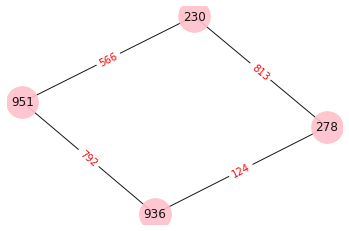

La chaîne construite correspond (dans l'odre) à : ['951', '278', '936', '230']


In [66]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt

NB_ANNOTED_RELATIONS = 0
NB_CHAINS_COMPUTED_RELATIONS = 0

xmlteifile_path = "../../../../ANCOR-dataset/data/train/source/024_C-3.tei"
print(xmlteifile_path)
file_reader = XMLTEIFileReader(xmlteifile_path)

file_mentions = file_reader.get_mentions()
file_relations = file_reader.get_coreferences()
file_chains = file_reader.compute_chains(file_relations)
# - On compare toutes les relations du fichier une à une, pour vérifier s'il existe un même lien décrit par deux
#   relations différentes
relations_list = [(set([file_relations[relation_name]["LEFT_NAME"], file_relations[relation_name]["RIGHT_NAME"]]), relation_name) 
                    for relation_name in list(file_relations.keys())]
relations_pairs_combinations = itertools.combinations(relations_list, 2)
duplicate_relations = set()
for relation_pair in relations_pairs_combinations:
    if (relation_pair[0][0] == relation_pair[1][0]): # égalité des paires décrites par des ensembles (l'ordre ne compte pas)
        #print(f"Même relation trouvée : {relation_pair[0]}, {relation_pair[1]}")
        duplicate_relations.add(relation_pair[0][1])
print(f"{len(duplicate_relations)} relations en double")


for chain_id in list(file_chains.keys()):
    chain_mention_set = set(file_chains[chain_id])
    all_possibles_mentions_couples = itertools.permutations(list(chain_mention_set), 2)
    NB_CHAIN_DESCRIBING_ANNOTATED_REL_FOUND = 0
    NB_CHAIN_RELATIONS = 0
    rel_found_set = set()
    for mention_couple in all_possibles_mentions_couples:
        left, right = mention_couple
        for rel in [k for k in list(file_relations.keys()) if k not in duplicate_relations]:
            left_name = file_relations[rel]["LEFT_NAME"]
            right_name = file_relations[rel]["RIGHT_NAME"]
            if ((left_name == left) and (right_name == right)):
                NB_CHAIN_DESCRIBING_ANNOTATED_REL_FOUND += 1
                rel_found_set.add(rel)
    
    name_to_order_dict = {}
    for chain_mention_id in range(len(file_chains[chain_id])-1):
        name_to_order_dict[file_chains[chain_id][chain_mention_id]] = chain_mention_id
        name_to_order_dict[file_chains[chain_id][chain_mention_id+1]] = chain_mention_id+1
        NB_CHAIN_RELATIONS += 1
    
    if (NB_CHAIN_DESCRIBING_ANNOTATED_REL_FOUND != NB_CHAIN_RELATIONS):
        print(f"Inégalité dans le chaîne {chain_id} : {NB_CHAIN_DESCRIBING_ANNOTATED_REL_FOUND} relations annotées pour former la chaîne vs. {NB_CHAIN_RELATIONS} maillons dans la chaîne.")
        edge_labels_dict = {}
        edges = []
        for rel_id, rel in enumerate(rel_found_set):
            left_name = file_relations[rel]["LEFT_NAME"]
            right_name = file_relations[rel]["RIGHT_NAME"]
            print(f"Relation {rel} : {left_name} -> {right_name}")
            edge_labels_dict[(str(left_name)[-3:], str(right_name)[-3:])] = str(rel)[-3:]
            edges.append([str(left_name)[-3:], str(right_name)[-3:]])
        G = nx.Graph()
        G.add_edges_from(edges)
        pos = nx.spring_layout(G)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_dict, font_color='red')
        nx.draw(G,pos,edge_color='black',width=1,linewidths=1, node_size=1000,node_color='pink',alpha=0.9, labels={node:node for node in G.nodes()})
        plt.show()
        
        print(f'La chaîne construite correspond (dans l\'odre) à : {[mention_name[-3:] for mention_name in file_chains[chain_id]]}')

## Testset

In [33]:
print(type(list(relation_pair[0])[1]))

set(["toto", "tata"]) == set(["tata", "toto"])

<class 'str'>


True

In [21]:
print(file_reader.get_chains())
print(file_reader.compute_chains(file_relations))


{0: ['u-MENTION-agoudjo_1337604468602', 'u-MENTION-agoudjo_1337604490179', 'u-MENTION-agoudjo_1337604727874', 'u-MENTION-agoudjo_1337607083262', 'u-MENTION-agoudjo_1337607156428', 'u-MENTION-agoudjo_1337608167778', 'u-MENTION-agoudjo_1337610094073'], 1: ['u-MENTION-agoudjo_1337604434006', 'u-MENTION-agoudjo_1337604509740'], 2: ['u-MENTION-agoudjo_1337604452774', 'u-MENTION-agoudjo_1337604572878', 'u-MENTION-agoudjo_1337604653816', 'u-MENTION-agoudjo_1337604681653', 'u-MENTION-agoudjo_1337604760556', 'u-MENTION-agoudjo_1337604817617', 'u-MENTION-jmuzerelle_1338562024055'], 3: ['u-MENTION-agoudjo_1337604894110', 'u-MENTION-agoudjo_1337604953540', 'u-MENTION-agoudjo_1337605031482', 'u-MENTION-agoudjo_1337605072622', 'u-MENTION-agoudjo_1337605102298', 'u-MENTION-agoudjo_1337605113764', 'u-MENTION-agoudjo_1337605419970', 'u-MENTION-agoudjo_1337605461997', 'u-MENTION-agoudjo_1337605705405', 'u-MENTION-agoudjo_1337605723614', 'u-MENTION-agoudjo_1337606212095', 'u-MENTION-agoudjo_1337606729556

{0: ['u-MENTION-agoudjo_1337604468602', 'u-MENTION-agoudjo_1337604490179', 'u-MENTION-agoudjo_1337604727874', 'u-MENTION-agoudjo_1337607083262', 'u-MENTION-agoudjo_1337607156428', 'u-MENTION-agoudjo_1337608167778', 'u-MENTION-agoudjo_1337610094073'], 1: ['u-MENTION-agoudjo_1337604434006', 'u-MENTION-agoudjo_1337604509740'], 2: ['u-MENTION-agoudjo_1337604452774', 'u-MENTION-agoudjo_1337604572878', 'u-MENTION-agoudjo_1337604653816', 'u-MENTION-agoudjo_1337604681653', 'u-MENTION-agoudjo_1337604760556', 'u-MENTION-agoudjo_1337604817617', 'u-MENTION-jmuzerelle_1338562024055'], 3: ['u-MENTION-agoudjo_1337604894110', 'u-MENTION-agoudjo_1337604953540', 'u-MENTION-agoudjo_1337605031482', 'u-MENTION-agoudjo_1337605072622', 'u-MENTION-agoudjo_1337605102298', 'u-MENTION-agoudjo_1337605113764', 'u-MENTION-agoudjo_1337605419970', 'u-MENTION-agoudjo_1337605461997', 'u-MENTION-agoudjo_1337605705405', 'u-MENTION-agoudjo_1337605723614', 'u-MENTION-agoudjo_1337606212095', 'u-MENTION-agoudjo_1337606729556

In [48]:
list(range(1))

[0]